In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA
# from skcuda.linalg import PCA as cuPCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from ta.volatility import AverageTrueRange, BollingerBands
from ta.trend import EMAIndicator
from ta.momentum import UltimateOscillator, StochasticOscillator, ROCIndicator, RSIIndicator, WilliamsRIndicator
# from statsmodels.tsa.arima_model import ARIMA
WS = 20

In [2]:
df = pd.read_csv('F:\\ut\\8\\proje\\data\\newbit.csv').dropna()
df = df.iloc[[x for x in range(0,20000,10)]]

In [88]:
class Bitcoin(nn.Module):
    def __init__(self,inSize, touples_index, variant_size, hiddenSize, outSize, ws):
        super().__init__()
        self.hiddenSize = hiddenSize
        self.inSize = inSize
        self.ws = ws
        self.touples_index = touples_index
        varient_lstm = []
        lstm = []
        for i, item in enumerate(variant_size):
            varient_lstm.append(nn.LSTM(2,item, num_layers=2, dropout=.3))
            varient_lstm.append(nn.LSTM(item, 1, num_layers=1, dropout=.2))
        self.varient_lstm = nn.ModuleList(varient_lstm)
        self.variant_size = variant_size
        for i,item in enumerate(hiddenSize):
            lstm.append(nn.LSTM(inSize,hiddenSize[i],num_layers=1,dropout=.2))
            inSize = hiddenSize[i]
        self.lstm = nn.ModuleList(lstm)
        self.linear = nn.Linear(hiddenSize[-1], outSize)
        self.reset()
        
    def reset(self):
        self.hiddenMemory =[]
        self.varient_mem = []
        for item in self.variant_size:
            self.varient_mem.append((torch.zeros(2,1,item).cuda(), torch.zeros(2,1,item).cuda()))
            self.varient_mem.append((torch.zeros(1,1,1).cuda(), torch.zeros(1,1,1).cuda()))
            
        for item in self.hiddenSize:
            self.hiddenMemory.append((torch.zeros(1,1,item).cuda(),\
                            torch.zeros(1,1,item).cuda()))
    def forward(self,seq):
#         seq=seq.view(self.ws, -1, self.inSize)
        var_x = seq[1]
        var_result = [0 for x in range(len(var_x))]
        for i in range(0, len(self.varient_mem), 2):
            x ,self.varient_mem[i]= self.varient_lstm[i](var_x[int(i/2)], self.varient_mem[i])
            var_result[int(i/2)] ,self.varient_mem[i+1]= self.varient_lstm[i+1](x, self.varient_mem[i+1])
        
        x = torch.cat(var_result, 2)
        seq = torch.cat((seq[0], x), 2)

        for i,item1 in enumerate(self.hiddenMemory):
            seq ,self.hiddenMemory[i]= self.lstm[i](seq, self.hiddenMemory[i])
        x = self.linear(seq)
        return x[-1]
instance = Bitcoin(3, [(1,2), (3,4)], [150,150], [200,250,300,100],1,WS).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(instance.parameters(), lr = .001)
torch.manual_seed(33)


In [79]:
def make_input(seq, ws, touples, st_col=0, end_col=0):
    output = []
    for item in range(len(seq) - ws):
        l = []
        for item2 in touples:
                l.append(torch.FloatTensor(seq[item:item+ws][ [item2[0], item2[1]] ].values.astype(float).reshape(ws, -1, 2)).cuda())
        
        not_used_col =set(range(st_col, end_col))
        for i in touples:
            not_used_col.remove(i[0])
            not_used_col.remove(i[1])

        not_used_col = list(not_used_col)
        output.append( ( (torch.FloatTensor( seq[item:item+ws][not_used_col].values.astype(float).reshape(ws, -1, len(not_used_col)) ).cuda(), l),\
                        torch.FloatTensor(np.array(seq[item + ws:item + ws+1][end_col])).cuda()) )
    return output



In [5]:
def add_indicators():
    added_columns = ['MA5','MA10','MA20', 'DIFF', 'BU', 'BL', 'Stochastic', \
                 'ROC', 'RSI6', 'RSI12', 'ATR', 'WR5', 'WR10', 'UOS'\
                     'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', \
                      'I28', 'I29'   ]
    close = df['Close']
    df['MA5'] = close.rolling(window=5).mean()
    df['MA10'] = close.rolling(window=10).mean()
    df['MA20'] = close.rolling(window=20).mean()
    df['DIFF'] = EMAIndicator(close, n=12).ema_indicator() - EMAIndicator(close, n=26).ema_indicator()
    df['BL']=BollingerBands(close, n=20, ndev=2).bollinger_lband()
    df['BU']=BollingerBands(close, n=20, ndev=2).bollinger_hband()
    df['Stochastic']=StochasticOscillator(df['High'], df['Low'], close).stoch()
    df['ROC'] = ROCIndicator(close).roc()
    df['RSI6'] = RSIIndicator(close, 6).rsi()
    df['RSI12'] = RSIIndicator(close, 12).rsi()
    df['ATR'] = AverageTrueRange(df['High'],df['Low'], close).average_true_range() 
    df['WR10'] = WilliamsRIndicator(df['High'],df['Low'], close, lbp=10).wr()
    df['WR5'] = WilliamsRIndicator(df['High'],df['Low'], close, lbp=5).wr()
    df['UOS'] = UltimateOscillator(df['High'],df['Low'], close,).uo()
    df['I28'] = close.diff(1) / close.shift(1)
    df['I29'] = (close - df['Open']) / df['Open']
    df['I30'] = (close - df['High']) / (df['High'] - df['Low'])
    df['I31'] = df['MA5'].diff(1) / df['MA5'].shift(1)
    df['I32'] = df['MA10'].diff(1) / df['MA10'].shift(1)
    df['I33'] = df['MA20'].diff(1) / df['MA20'].shift(1)
    df['I34'] = df['MA5'].diff(1) / df['MA20'].shift(1)
    df['I35'] = (close - np.array([np.amin(close[:x]) for x in range(len(close))]))/np.array([np.amin(close[:x]) for x in range(len(close))])
    df['I36'] = (close - np.array([np.amax(close[:x]) for x in range(len(close))]))/np.array([np.amax(close[:x]) for x in range(len(close))])
    df.dropna(inplace= True)
    return added_columns


In [54]:
instance = Bitcoin(3, [(1,2), (3,4)], [100,100], [200,100],1,WS).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(instance.parameters(), lr = .001)
torch.manual_seed(33)



In [80]:
traincol = ['Open','High','Low', 'Close', 'Volume_(Currency)', ]
resultCol = ['Weighted_Price']
scaler = MinMaxScaler(feature_range=(-1, 1 ))
# add_indicators()
new_df=np.append(df[traincol], df['Close'].values.astype(float).reshape(-1,1), axis=1)
new_df = pd.DataFrame(data=new_df)

train_set = np.array(new_df[-500:-100].values.astype(float))
train_set = scaler.fit_transform(train_set)
train_set = pd.DataFrame(train_set)
train_set = make_input(train_set, WS, [(1,2), (3,4)], st_col=0, end_col=5)

test = new_df[-100:].values.astype(float)
test = scaler.fit_transform(test)
test = pd.DataFrame(test)
test = make_input(test,WS,[(1,2), (3,4)], st_col=0, end_col=5)


In [81]:
# train_set = pd.DataFrame(train_set)
test[0][0][0]
# pd.DataFrame(df[traincol].values.astype(float))[:20][[0]].values.astype(float)

tensor([[[-0.0122]],

        [[-0.1016]],

        [[-0.0490]],

        [[-0.0091]],

        [[-0.0283]],

        [[-0.0233]],

        [[-0.0418]],

        [[ 0.0290]],

        [[ 0.0297]],

        [[ 0.0159]],

        [[-0.0773]],

        [[-0.0172]],

        [[-0.2027]],

        [[-0.1970]],

        [[-0.2542]],

        [[-1.0000]],

        [[-0.7658]],

        [[-0.4621]],

        [[-0.4744]],

        [[ 0.0035]]], device='cuda:0')

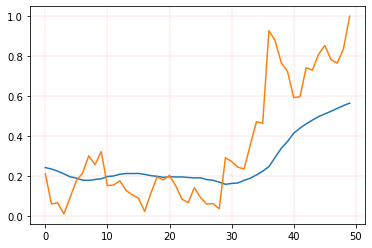

0 tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)


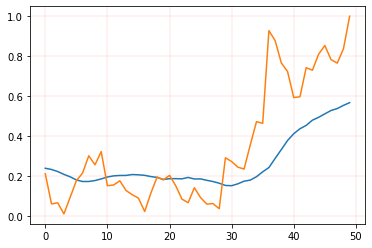

1 tensor(2.7146e-05, device='cuda:0', grad_fn=<MseLossBackward>)


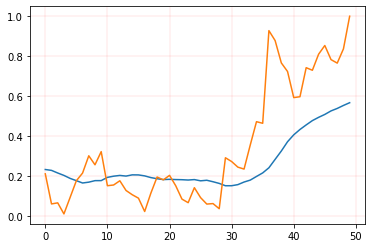

2 tensor(3.6359e-06, device='cuda:0', grad_fn=<MseLossBackward>)


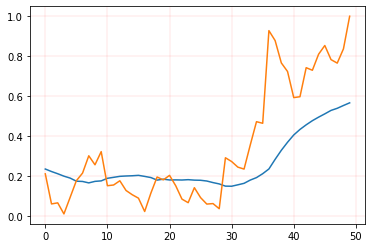

3 tensor(6.9747e-05, device='cuda:0', grad_fn=<MseLossBackward>)


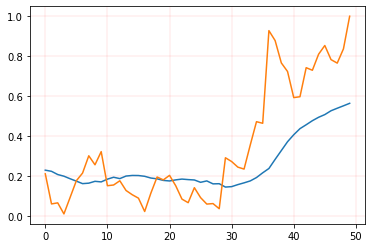

4 tensor(4.7313e-05, device='cuda:0', grad_fn=<MseLossBackward>)


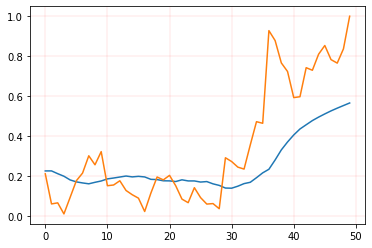

5 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


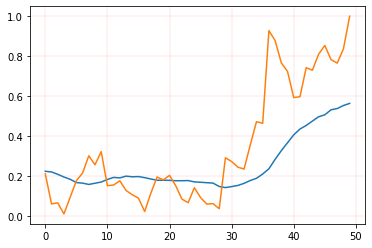

6 tensor(2.8251e-05, device='cuda:0', grad_fn=<MseLossBackward>)


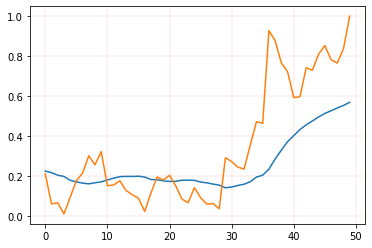

7 tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [91]:
epoch = 200
preds_in_learn = []
reals_in_learn = []
optimizer = torch.optim.Adam(instance.parameters(), lr=.000001)
for i in range(epoch):
    for seq, y in train_set:
        instance.reset()
        pred = instance.forward(seq)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    with torch.no_grad():
        for item , y in test:
            instance.reset()
            preds_in_learn.append(instance.forward(item))
            reals_in_learn.append(y)
    plt.plot(range(50), preds_in_learn[-50:],)
    # plt.show()
    plt.grid(color='r', linestyle='-', linewidth=.1, zorder=.1)
    # plt.show()
    plt.plot(range(50), reals_in_learn[-50:])
    plt.show()
    preds_in_learn.clear()
    reals_in_learn.clear()
    print(i, loss)

In [ ]:
# instance.eval()
preds = []
real = []
with torch.no_grad():
    for item, y in test:
        instance.reset()

        preds.append(instance.forward(item))
        real.append(y)
plt.plot(range(60), preds[-60:],)
# plt.show()
plt.grid(color='r', linestyle='-', linewidth=.1, zorder=.1)
# plt.show()
plt.plot(range(60), real[-60:])
plt.show()